### Prediction of scraped MyAnimeList Data ###

Our goal in this project is to predict the popularity ranking of a supposed new show coming out using the basic information we would know about it before airing. <br>
We scraped our data from the side MyAnimeList (MAL for short). Link: https://myanimelist.net <br>
Example page from which we extracted data: (Attack on Titan) https://myanimelist.net/anime/16498

Importing 'numpy', 'pandas', 'matplotlib' and 'seaborn' for data management and visualization. 

In [2642]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Prevent redundant warnings from pandas.

In [2643]:
import warnings
warnings.filterwarnings('ignore')

Reading the scraped data. The columns given regarding a show:
 - Title.
 - MAL Id. This method's input, its returned for convenience.
 - Type. For example: 'Movie', 'TV', ect.
 - Episode's duration. For example: '23 min', '2 hour', ect.
 - Publishing animation studio.
 - Source type. For example: 'Manga', 'Visual' (short for Visual Novel), ect.
 - Genres. For example: 'Fantasy', 'Romance', 'Action', etc.
 - Themes. For example: 'Military', 'Apocalypse', etc.
 - Rating. For example: 'PG-13'.
 - Popularity. Popularity ranking, lower is better.
 - Score. x out of 10, given by MAL user.
 - Year. Release year. For example: '2022'.
 - Number of Episodes. For example: '24'.
 - Demographic. Intended demographic. For example: 'shonen' (meaning young boys).

<b> Important Notes: </b> (TL;DR)
* Anime with lower Popularity means it was ranked lower, hence it means that the anime was viewed by more people.
* During our analysis and model training we won't be using the given Score of an anime to avoid data leakage as a popular anime is more likely to have a better score.

In [2644]:
df = pd.read_csv("anime_df_raw.csv", sep=';')
df.head(10)

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,R - 17+ (violence & profanity),3,9.15,Shounen,2009
1,1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),220,9.15,Shounen,2022
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,PG-13 - Teens 13 or older,13,9.09,N\A,2011
3,3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,335,9.09,Shounen,2015
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),32,9.08,Shounen,2019
5,5,Fruits Basket: The Final,42938,TV,13,23 min. per ep.,TMS Entertainment,Manga,"Drama,Romance,Slice of Life,Supernatural",N\A,PG-13 - Teens 13 or older,626,9.06,Shoujo,2021
6,6,Gintama',9969,TV,51,24 min. per ep.,Sunrise,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,380,9.06,Shounen,2011
7,7,Gintama: The Final,39486,Movie,1,1 hr. 44 min.,Bandai Namco Pictures,Manga,"Action,Comedy,Drama,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,1798,9.05,Shounen,2021
8,8,Hunter x Hunter (2011),11061,TV,148,23 min. per ep.,Madhouse,Manga,"Action,Adventure,Fantasy",N\A,PG-13 - Teens 13 or older,10,9.05,Shounen,2011
9,9,Gintama': Enchousen,15417,TV,13,24 min. per ep.,Sunrise,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,683,9.04,Shounen,2012


Delete null information. (if exists)

In [2645]:
data_null_total = pd.DataFrame(df.isna().sum()).T.rename({0:'total null'})
data_null_total

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year
total null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204


Check for duplicated data entries.

In [2646]:
df = df.drop_duplicates(keep='first')

Lets remove entries with 'None' data:
 - 'add some' is a placeholder of shows without a known studio.
 - 'Unknown' source type.
 - All shows without listed genres.
 - All shows without a release year.

In [2647]:
#no_studio = df[df['Studios'].str.contains('add some')]
#df = pd.concat([df, no_studio])
#df = df.drop_duplicates(keep=False)

#print( 'Removed {} entries.'.format(len(no_studio.index)) )

In [2648]:
no_source = df[df['Source Type'].str.contains('Unknown')]
df = pd.concat([df, no_source])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_source.index)) )

Removed 1289 entries.


In [2649]:
no_genre = df[df['Genres'] == 'N\A']
df = pd.concat([df, no_genre])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_genre.index)) )

Removed 1877 entries.


In [2650]:
no_ep_num = df[df['Number of Episodes'] == 'Unknown']
df = pd.concat([df, no_ep_num])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_ep_num.index)) )

Removed 28 entries.


In [2651]:
clean_df = df[pd.to_numeric(df['Year'], errors='coerce').notnull()]

print( 'Removed {} entries.'.format(len(df.index) - len(clean_df.index)) )
df = clean_df

Removed 69 entries.


In [2652]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6234 entries, 0 to 9493
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          6234 non-null   int64  
 1   Title               6234 non-null   object 
 2   MAL Id              6234 non-null   int64  
 3   Type                6234 non-null   object 
 4   Number of Episodes  6234 non-null   object 
 5   Episode Duration    6234 non-null   object 
 6   Studios             6234 non-null   object 
 7   Source Type         6234 non-null   object 
 8   Genres              6234 non-null   object 
 9   Themes              6234 non-null   object 
 10  Rating              6234 non-null   object 
 11  Popularity          6234 non-null   int64  
 12  Score               6234 non-null   float64
 13  Demographic         6234 non-null   object 
 14  Year                6234 non-null   object 
dtypes: float64(1), int64(3), object(11)
memory usage: 779.2

Lets parse the data that is still saved as a string so we can work with it.

Lets convert the Release year to 'int'.

In [2653]:
df['Year'] = df['Year'].astype(int)

lets convert 'Number of Episodes' to an 'int.

In [2654]:
df['Number of Episodes'] = df['Number of Episodes'].astype(int)

Parsing Episode Duration to 'int' minutes.

In [2655]:
def DurationToMin(duration_str):
    duration_list = duration_str.split(' ')
    duration = 0

    i = 0
    for word in duration_list:
        if word == 'min.':
            duration += int(duration_list[i-1])
        elif word == 'hr.':
            duration += 60*int(duration_list[i-1])
        i += 1

    return duration

In [2656]:
df['Duration'] = df['Episode Duration'].apply(lambda x: DurationToMin(x))

In [2657]:
df = df.drop(['Unnamed: 0'], axis=1)

Lets remove shows with episode duration smaller than 1 minute.

In [2658]:
no_duration = df[df['Duration'] == 0]
df = pd.concat([df, no_duration])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_duration.index)) )

Removed 21 entries.


In [2659]:
df

,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year,Duration
0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,R - 17+ (violence & profanity),3,9.15,Shounen,2009,24
1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),220,9.15,Shounen,2022,23
2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,PG-13 - Teens 13 or older,13,9.09,N\A,2011,24
3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,335,9.09,Shounen,2015,24
4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),32,9.08,Shounen,2019,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9484,Ugokie Kori no Tatehiki,3929,Movie,1,11 min.,add some,Original,"Comedy,Supernatural",N\A,G - All Ages,10841,5.66,N\A,1933,11
9487,California Crisis: Tsuigeki no Juuka,3127,OVA,1,45 min.,"Studio Unicorn,Hiro Media",Original,"Action,Adventure,Sci-Fi",N\A,PG-13 - Teens 13 or older,7041,5.66,N\A,1986,45
9491,Hipira-kun ONA,22983,ONA,2,5 min. per ep.,Sunrise,Picture,"Comedy,Fantasy,Supernatural",N\A,PG - Children,11824,5.66,Kids,2010,5
9492,Install Pilot,11043,Special,1,12 min.,Asahi Production,Original,"Action,Sci-Fi",N\A,R - 17+ (violence & profanity),12229,5.66,Shounen,2011,12


The models cannot accept string values hence we will create boolean values for each genre related to a show. We will convert the True/False value into 1/0 (respectively) for it to be numerical data.

In [2660]:
def GetAttributeList(column, dataframe, none_value):
    attribute_list = []
    for cell in dataframe[column]:
        attributes = cell.split(',')
        for attribute in attributes:
            if attribute not in attribute_list and none_value not in attribute:
                attribute_list.append(attribute)

    return attribute_list

def AttributeListToBoolFlags(column, dataframe, none_value):
    attribute_list = GetAttributeList(column, dataframe, none_value)

    print( 'There are {} {}.\n {}'.format(len(attribute_list), column, attribute_list) )

    for attribute in attribute_list:
        dataframe[attribute] = dataframe.apply (lambda row: 1 if attribute in row[column] else 0, axis=1)

In [2661]:
AttributeListToBoolFlags('Genres', df, 'N\A')
AttributeListToBoolFlags('Themes', df, 'N\A')
AttributeListToBoolFlags('Source Type', df, 'Other')

There are 20 Genres.
 ['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi', 'Suspense', 'Romance', 'Slice of Life', 'Supernatural', 'Sports', 'Award Winning', 'Ecchi', 'Horror', 'Avant Garde', 'Boys Love', 'Gourmet', 'Girls Love', 'Work Life']
There are 17 Themes.
 ['Military', 'Super Power', 'Historical', 'Parody', 'Samurai', 'Space', 'Mecha', 'Demons', 'Martial Arts', 'School', 'Music', 'Psychological', 'Police', 'Game', 'Harem', 'Vampire', 'Cars']
There are 15 Source Type.
 ['Manga', 'Visual', 'Novel', 'Light', 'Original', 'Web', '4-koma', 'Book', 'Game', 'Picture', 'Card', 'Music', 'Mixed', 'Digital', 'Radio']


lets remove the genres that we barely see (< 5 times), if left alone they would serve as edge cases for our predictions.

In [2662]:
genre_list = GetAttributeList('Genres', df, 'N\A')

for genre in genre_list:
    count = df[genre].value_counts()[1]
    if count < 5:
        df = df.drop(genre, axis=1)

genre_list = GetAttributeList('Themes', df, 'N\A')

for genre in genre_list:
    count = df[genre].value_counts()[1]
    if count < 5:
        df = df.drop(genre, axis=1)

genre_list = GetAttributeList('Source Type', df, 'Other')

for genre in genre_list:
    count = df[genre].value_counts()[1]
    if count < 10:
        df = df.drop(genre, axis=1)

The models cannot accept string values hence we will create boolean values for the rating, type and demographic related to each show just as we did for genre.

In [2663]:
AttributeListToBoolFlags('Rating', df, 'None')
AttributeListToBoolFlags('Type', df, 'N\A')
AttributeListToBoolFlags('Demographic', df, 'N\A')

There are 5 Rating.
 [' R - 17+ (violence & profanity)  ', ' PG-13 - Teens 13 or older  ', ' R+ - Mild Nudity  ', ' PG - Children  ', ' G - All Ages  ']
There are 5 Type.
 ['TV', 'Movie', 'OVA', 'ONA', 'Special']
There are 5 Demographic.
 ['Shounen', 'Shoujo', 'Seinen', 'Josei', 'Kids']


After removing a large quantity of entries the 'Popularity' column, which represents the show's popularity <b> rank </b>, would have gaps in its values, leading to an unbalanced data set. We will bridge those rankings while keeping their original order to avoid the issue.

In [2664]:
df.sort_values('Popularity')
df = df.reset_index(drop=True)

for index, value in df.iterrows():
    df.loc[index, 'Popularity'] = index

Now the 'index' column and the 'popularity' column are identical. To avoid data leakage we will remove the index column and reset them after shuffling the dataframe.

In [2665]:
#df = df.drop(['index'], axis=1)
df['Popularity']

0          0
1          1
2          2
3          3
4          4
        ... 
6208    6208
6209    6209
6210    6210
6211    6211
6212    6212
Name: Popularity, Length: 6213, dtype: int64

Lets shuffle the data.

In [2666]:
df = df.sample(frac=1).reset_index(drop=True)

In [2667]:
df.to_csv("anime_df_clean.csv", sep=';', index=False)
df

,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,...,TV,Movie,OVA,ONA,Special,Shounen,Shoujo,Seinen,Josei,Kids
0,Daishizen no Majuu: Bagi,2312,Movie,1,1 hr. 30 min.,add some,Original,"Action,Romance,Sci-Fi",N\A,PG-13 - Teens 13 or older,...,0,1,0,0,0,0,0,0,0,0
1,Jibaku Shounen Hanako-kun,39534,TV,12,24 min. per ep.,Lerche,Manga,"Comedy,Supernatural",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,1,0,0,0,0
2,Asobot Senki Gokuu,3193,TV,52,23 min. per ep.,Studio Egg,Manga,"Action,Adventure,Comedy,Sci-Fi",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,1,0,0,0,0
3,Kekkai Sensen & Beyond,34451,TV,12,24 min. per ep.,Bones,Manga,"Action,Comedy,Fantasy,Supernatural","Super Power,Vampire",R - 17+ (violence & profanity),...,1,0,0,0,0,1,0,0,0,0
4,Dragon Ball Z Special 2: Zetsubou e no Hankou!...,985,Special,1,48 min.,Toei Animation,Manga,"Adventure,Drama,Fantasy",N\A,PG-13 - Teens 13 or older,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6208,Kobo-chan,19585,TV,63,25 min. per ep.,Eiken,4-koma,"Comedy,Slice of Life",N\A,G - All Ages,...,1,0,0,0,0,0,0,0,0,1
6209,Eat-Man,1704,TV,12,24 min. per ep.,Studio Deen,Manga,"Action,Adventure,Sci-Fi",N\A,R - 17+ (violence & profanity),...,1,0,0,0,0,1,0,0,0,0
6210,D.C.S.S: Da Capo Second Season,291,TV,26,25 min. per ep.,feel.,Visual,"Comedy,Drama,Romance,Supernatural",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
6211,Aiura,17082,TV,12,4 min. per ep.,LIDENFILMS,4-koma,"Comedy,Slice of Life",N\A,G - All Ages,...,1,0,0,0,0,1,0,0,0,0


Now that we cleaned the data we will try to gain some insight into the correlation between parameters and confirm our own suspicions.

### Correlation ###

In [2668]:
def CorrelationTable(data, title):
    # Compute the correlation matrix:
    pandas_correlation = data.corr()

    # Generating a mask for the upper triangle for a cleaner table:
    mask = np.triu(np.ones_like(pandas_correlation, dtype=bool))

    # Set up the matplotlib figure:
    f, ax = plt.subplots(figsize=(50, 50))

    # Generate a custom diverging colormap:
    cmap = sns.diverging_palette(20, 230, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio:
    sns.heatmap(pandas_correlation, mask=mask, cmap=cmap, vmax=.8, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    # Title:
    plt.title(title)

    plt.show()

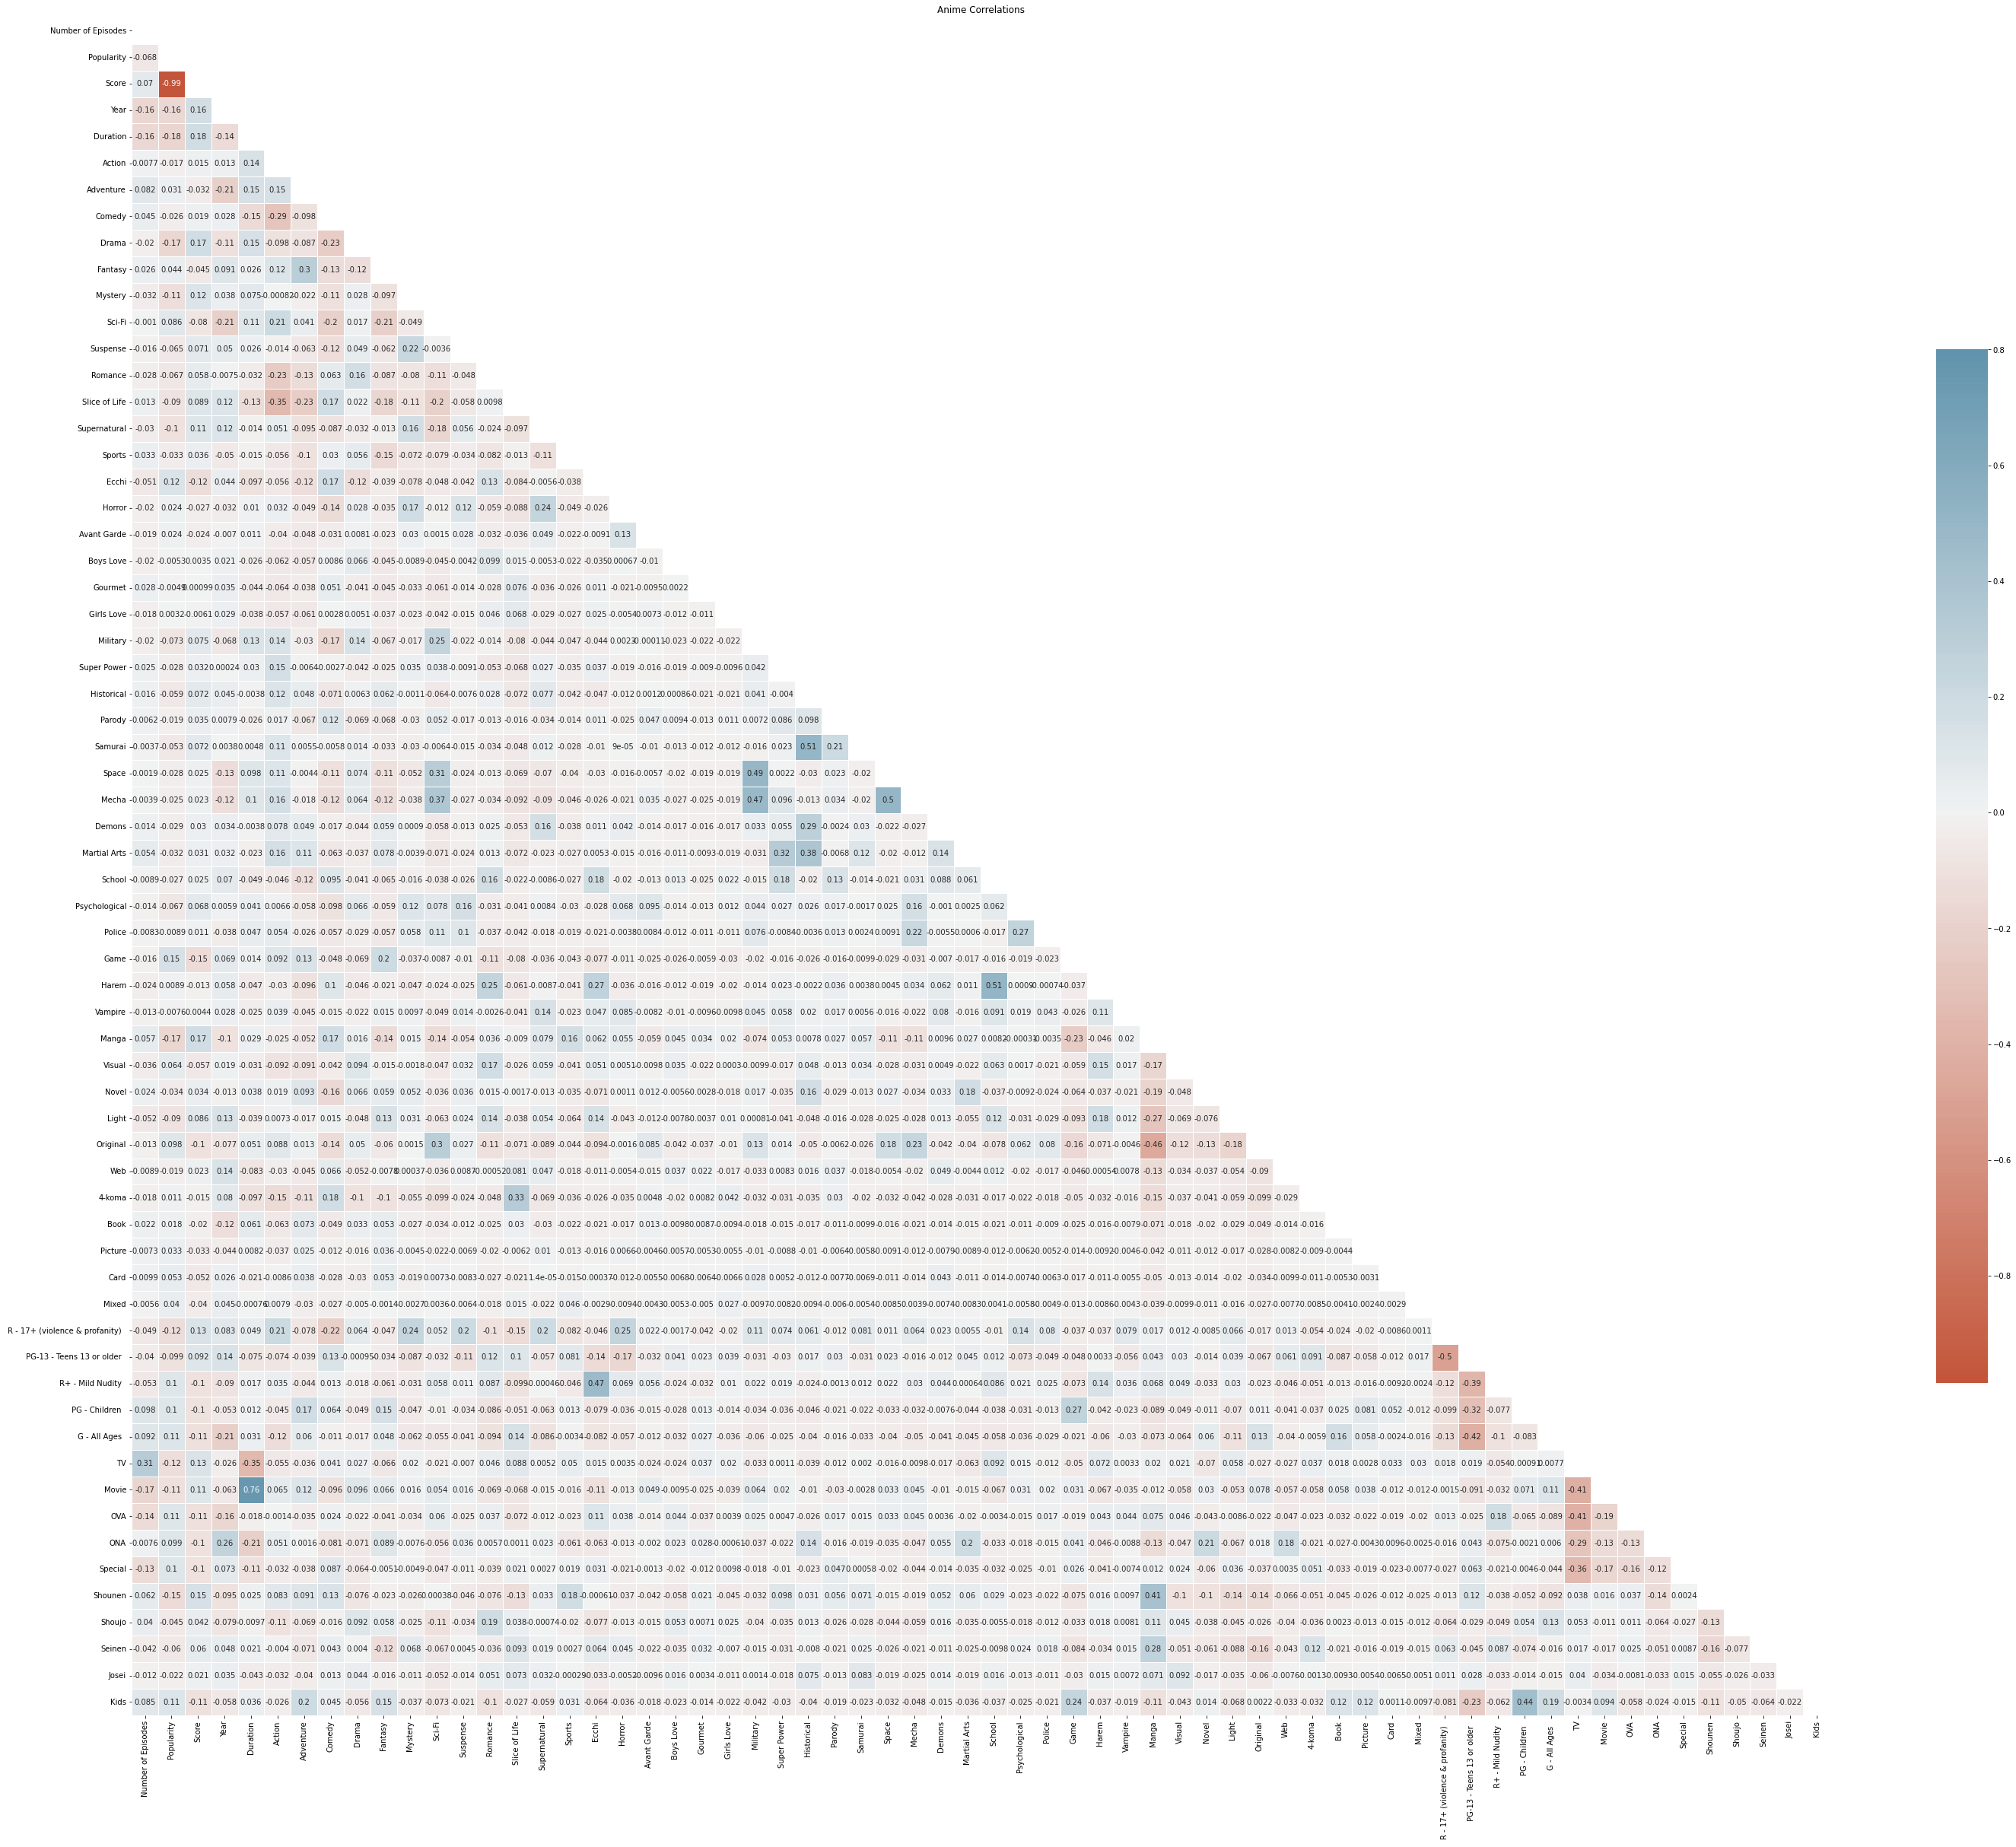

In [2669]:
corr_df = df.drop(['Title', 'Episode Duration', 'Genres', 'Themes', 'Studios', 'Source Type', 'Type', 'Rating', 'Demographic', 'MAL Id'], axis=1)
CorrelationTable(corr_df, 'Anime Correlations')

<b> Reminder! </b> <br>
Anime with lower Popularity means it was ranked lower, hence it means that the anime was viewed by more people.
In addition, we looked at Score even though we will not use it because of its strong connection to Popularity in order to gain further insight.

<b> Important connections: </b> (Relatively strong relations to popularity)
* Year, Popularity : (-0.16) There is a strong connection between year and popularity, that shows new anime tend to be more popular (ranked lower).
* Duration, Populairty : (-0.18)  We can infer that the longer anime's episodes are, the more popular it gets.
* Drama, Popularity: (-0.17) Anime with Drama genre tend to get a lower rank.
* Mystery, Popularity: (-0.11) Anime with Mystery genre tend to get a lower rank.
* Supernatrual, Popularity: (-0.1)  Anime with Supernatrual genre tend to get a lower rank.
* Ecchi, Popularity: (0.12) Anime with Ecchi genre tend to get a higher rank.
* Game, Popularity : (0.15) Anime with Game genre tend to get higher rank.
* Manga, Popularity : (-0.17) Anime with manga source tend to be lower ranked (better).
* Light, Popularity : (-0.09) Anime with Light novel source tend to get lower rank.
* R - 17+ (violence & profanity), Popularity: (-0.12) Anime with this rating tends to be lower ranked.
* G - All Ages, Popularity: (0.11)  Indicates that anime for all ages tend to be higher ranked.
* TV, Popularity: (-0.12) There is a positive connection between anime's rank and the fact it was aired on TV.
* ONA, Popularity: (0.099) There is a relatively strong connection between anime's rank and the fact it was aired on a website.
* Shounen, Popularity: (-0.15) Anime with Shounen demography tend to get lower ranked.
* Kids, Popularity: (0.11) Anime for kids tend to be higher ranked.

<b> Relatively strong connections to score: </b>
* Duration , Score: (0.18) Anime with higher duration per episode tend to get a better score.
* Drama, Score: (0.17) Anime with Drama genre tend to get higher score.
* Supernatural, Score: (0.11): Anime with supernatural genre tend to get higher score.
* R - 17+ (violence & profanity), Score: (0.13) Anime with this rating tends to get higher score.
* TV, Score: (0.1) Anime that was aired on TV tend to get higher score.
* Shounen, Score : (0.14) Anime with Shounen demography tend to get higher score.
* Kids, Score: (-0.1) Anime for kids tend to get lower score.
* Score, Number of Episodes: (0.073) Anime with more episodes tend to get a greater score.
* Year, Score: (0.16) New anime tend to receive a greater score.

We expect that an anime with the following data will be relatively lower ranked (With lower Popularity):
* The anime was released in the last few years
* The anime's episdoe's duration is relatively long
* The anime's genres are: Drama, Supernatural , Mystery
* The anime's source is Manga or Light novel 
* The anime is rated 17+ (violence & profanity)
* The anime was aired on TV
* The anime's demography is Shounen

We expect that an anime with the following data will be relatively higher ranked (With higher popularity):
* The anime was released a relatively long time ago
* The anime's episode's duration is relatively short.
* The anime's genres are: Ecchi, Sci-Fi, Game
* The anime is rated for all ages / childern
* The anime was aired on a website 
* The anime demography is kids

## Graphs ##

We use this graph to see how many times each genre appear in order to get a better understanding of our data.
For example, which genre is the most used.

We expect that if a genre appears a low number of times, it means that anime with that genre will have a relatively higher Popularity value, meaning worse.

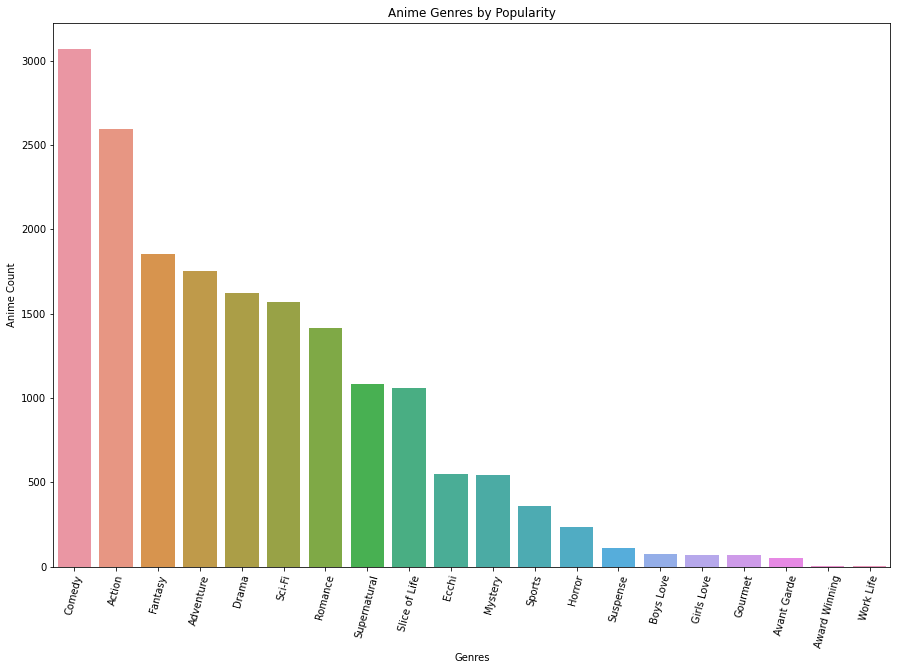

In [2670]:
#cut genres
#median genre popularity
#make chart of genre vs populrity
genre_list = []

genre_splited = []

for i in df['Genres']:
    for j in i.split(","):
        genre_splited.append(j)
        if j not in genre_list:
            genre_list.append(j)   
        
anime_genres_count = pd.Series(genre_splited).value_counts() 

plt.figure(figsize=(15,10))
sns.barplot(x=anime_genres_count.index.tolist(), y=anime_genres_count.tolist())
plt.xlabel('Genres')
plt.ylabel('Anime Count')
plt.title('Anime Genres by Popularity') 
plt.xticks(rotation= 75)
plt.show()

In [2671]:
MedPop_genre = []
genre_list.remove('Award Winning')
genre_list.remove('Work Life')
for genre in genre_list:
    try:
        genre_appears = df[df[genre]==1]
        MedPop_genre.append(genre_appears['Popularity'].median())
    except:
        print(genre)
    
MedPop_genre

[3019.0,
 2754.0,
 3440.0,
 3088.0,
 2472.5,
 3217.0,
 3245.5,
 2412.0,
 2184.0,
 3901.0,
 2597.5,
 3075.0,
 2647.0,
 3084.0,
 2958.0,
 4072.5,
 1629.5,
 3367.0]

This graph allows us to get a better understanding of the data. We can infer from this graph that we can expect anime with Suspense (or Mystery) to be relatively lower ranked 

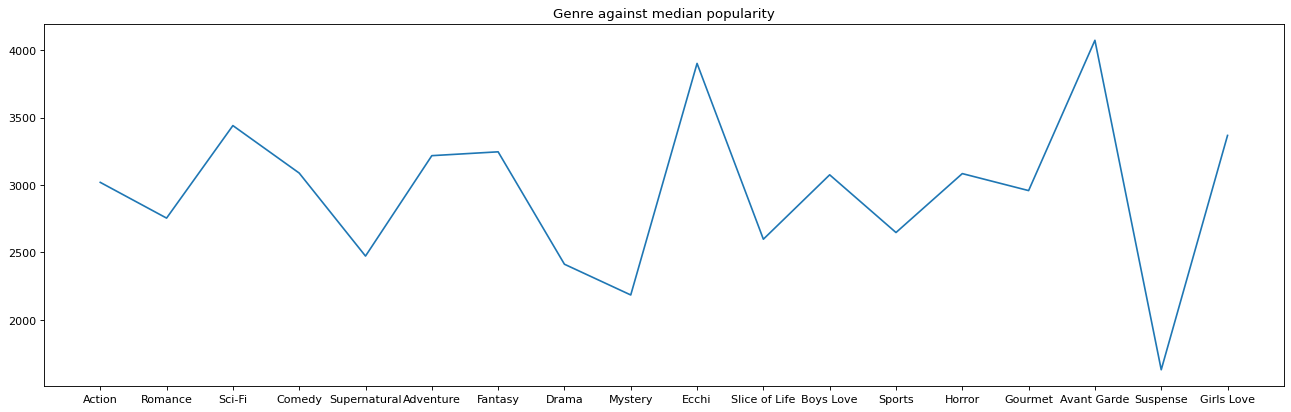

In [2672]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)
plt.title('Genre against median popularity')
plt.plot(genre_list,MedPop_genre)

We use this Graph to check how balance our data is: Since we remove some of our data, we had to verify that we have samples of low and high popularity anime.

<AxesSubplot:title={'center':'How many times each popularity appears modul 500'}, xlabel='Popularity'>

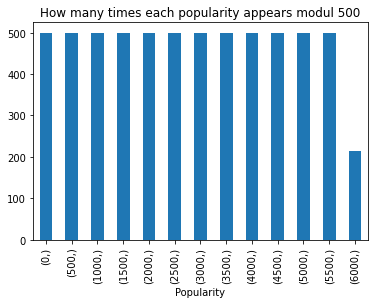

In [2673]:
plt.title('How many times each popularity appears modul 500')
df_popularity = df[['Popularity']].apply(lambda x: (x-(x%500)))
df_popularity

df_popularity_count = df_popularity.value_counts()
df_popularity_count.plot(kind = 'bar')

We use this graph to see how many times each source appear in order to get a better understanding of our data.
For example, which source is the most common.

We expect that if a source appears a low number of times, it means that anime with that source will have a relatively higher Popularity value, meaning worse.

<AxesSubplot:title={'center':'Source and the Number of Published Anime'}>

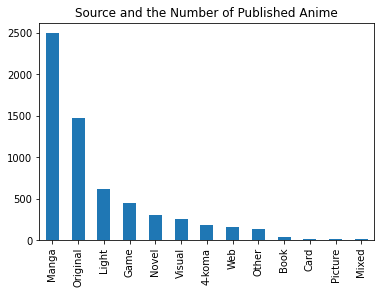

In [2674]:
plt.title('Source and the Number of Published Anime')
source_appearances = df['Source Type'].value_counts()
source_appearances[source_appearances>10].plot(kind = 'bar')

In [2675]:
df_lowpop = df[df['Popularity']<100]
df_lowpop

,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,...,TV,Movie,OVA,ONA,Special,Shounen,Shoujo,Seinen,Josei,Kids
32,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,R - 17+ (violence & profanity),...,1,0,0,0,0,1,0,0,0,0
95,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,44,OVA,4,30 min. per ep.,Studio Deen,Manga,"Action,Drama,Romance","Historical,Martial Arts,Samurai",R - 17+ (violence & profanity),...,0,0,1,0,0,1,0,0,0,0
169,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,...,1,0,0,0,0,1,0,0,0,0
336,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,42203,TV,12,28 min. per ep.,White Fox,Light,"Drama,Fantasy,Suspense",N\A,R - 17+ (violence & profanity),...,1,0,0,0,0,0,0,0,0,0
363,Kara no Kyoukai 5: Mujun Rasen,4282,Movie,1,1 hr. 54 min.,ufotable,Light,"Action,Drama,Mystery,Romance,Supernatural,Susp...",N\A,R - 17+ (violence & profanity),...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,Ousama Ranking,40834,TV,23,23 min. per ep.,Wit Studio,Web,"Adventure,Fantasy",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
5915,Hajime no Ippo,263,TV,75,23 min. per ep.,Madhouse,Manga,"Comedy,Drama,Sports",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,1,0,0,0,0
5918,Kimetsu no Yaiba,38000,TV,26,23 min. per ep.,ufotable,Manga,"Action,Supernatural","Demons,Historical",R - 17+ (violence & profanity),...,1,0,0,0,0,1,0,0,0,0
5984,Kizumonogatari III: Reiketsu-hen,31758,Movie,1,1 hr. 23 min.,Shaft,Light,"Action,Mystery,Supernatural",N\A,R - 17+ (violence & profanity),...,0,1,0,0,0,0,0,0,0,0


We used this graph to get a better understanding of how our top 100 animes look like. (Conclusions on the top of the next graph)

<AxesSubplot:title={'center':'Source and the Number of Published Anime for Low Popularity (better) Anime'}>

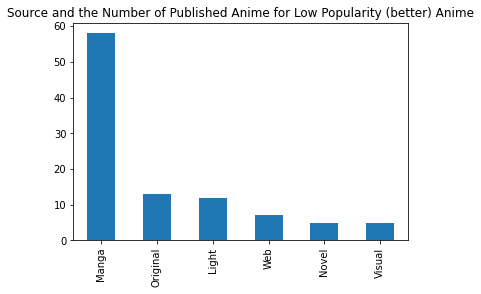

In [2676]:
plt.title('Source and the Number of Published Anime for Low Popularity (better) Anime')
source_appearances = df_lowpop['Source Type'].value_counts()
source_appearances[source_appearances>0].plot(kind = 'bar')

In [2677]:
df_highpop = df[df['Popularity']>5000]
df_highpop

,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,...,TV,Movie,OVA,ONA,Special,Shounen,Shoujo,Seinen,Josei,Kids
0,Daishizen no Majuu: Bagi,2312,Movie,1,1 hr. 30 min.,add some,Original,"Action,Romance,Sci-Fi",N\A,PG-13 - Teens 13 or older,...,0,1,0,0,0,0,0,0,0,0
9,Xin Jue,42148,ONA,13,21 min. per ep.,add some,Original,"Action,Adventure,Sci-Fi",N\A,PG-13 - Teens 13 or older,...,0,0,0,1,0,0,0,0,0,0
13,Weiß Survive R,7463,TV,12,2 min. per ep.,Studio Hibari,Card,"Comedy,Ecchi",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
21,Tsuki wa Higashi ni Hi wa Nishi ni: Operation ...,12881,OVA,4,12 min. per ep.,add some,Visual,"Comedy,Drama,Romance,Sci-Fi",N\A,PG-13 - Teens 13 or older,...,0,0,1,0,0,0,0,0,0,0
24,Duel Masters Victory V3,21999,TV,51,24 min. per ep.,add some,Original,"Action,Adventure,Comedy,Fantasy",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,Muteking the Dancing Hero,39893,TV,12,23 min. per ep.,"Tatsunoko Production,Tezuka Productions",Original,"Action,Comedy,Sci-Fi",N\A,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
6185,Aki-Sora: Yume no Naka,8577,OVA,2,24 min. per ep.,Hoods Entertainment,Manga,"Romance,Ecchi",N\A,R+ - Mild Nudity,...,0,0,1,0,0,0,0,1,0,0
6188,Dou Shen Ji,50021,ONA,12,24 min. per ep.,Seven Stone Entertainment,Original,"Action,Sci-Fi","Mecha,Space",PG-13 - Teens 13 or older,...,0,0,0,1,0,0,0,0,0,0
6194,Meng Ta: Xue Mi Cheng,38688,ONA,13,21 min. per ep.,add some,Original,"Action,Adventure,Fantasy,Mystery,Supernatural",N\A,PG-13 - Teens 13 or older,...,0,0,0,1,0,0,0,0,0,0


We can conclude that Light Novels ('Light') for example appears many times in our top 100, and way less on 5000+. Hence, we expect that anime with Light source will recieve lower rank (which means better anime)

<AxesSubplot:title={'center':'Source and the Number of Published Anime for Low Popularity Anime'}>

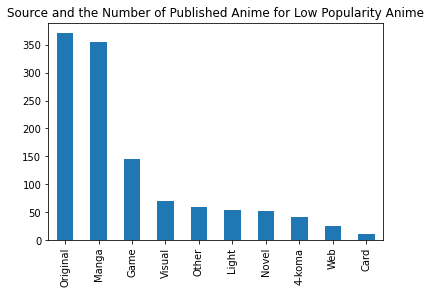

In [2678]:
plt.title('Source and the Number of Published Anime for Low Popularity Anime')
source_appearances = df_highpop['Source Type'].value_counts()
source_appearances[source_appearances>10].plot(kind = 'bar')

We can see that 'Manga' appears in both graphs, we already know that manga is the most common source type and now we would conclude that its influence on popularity is negligible. <br>
In addition we can see that most unpopular anime are original shows but there are some original anime that is well received, in accordance to our expectation, it would be harder to produce a successful show without base martial to work with. 

## Models ##

First of all we will split the data into a training set and a final test set.

In [2679]:
from sklearn.model_selection import train_test_split

x = df.drop(['Title', 'Episode Duration', 'Genres', 'Themes', 'Popularity', 'Studios', 'Source Type', 'Type', 'Rating', 'Demographic', 'MAL Id', 'Score'], axis=1)
y = df[['Popularity']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Dummies ###
To be able to truly understand and asses our models’ performance, we would need to establish a baseline for the data that we have. For that we would use a Dummy Model that doesn't try and find patterns in the given data. <br>
Lets run a dummy model to get our baseline:

In [2680]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

In [2681]:
dummy_regr = DummyRegressor(strategy="mean")
score = abs(np.median(cross_val_score(dummy_regr, x_train, y_train, cv=30)))

print('Dummy\'s Score: {}'.format(score))

Dummy's Score: 0.0038768534891483464


### K Nearest Neighbor ###
K nearest neighbor is a relatively simple algorithm that is built around the concept that similar, or close, data would give similar results. In other words, similar things are near to each other.
The algorithm would search for the K nearest points (in the train sample) on the x axises and predicts that the y value would be a combination of those k point's y value.

In [2682]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

Lets find the most suitable K (nearest neighbors).

In [2683]:
k_range = range(1, 31)

scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    score = np.median(cross_val_score(knn, x_train, y_train, cv=30))
    scores.append(score)

max_k_score = np.max(scores[1:])
max_k = scores.index(max_k_score) + 1
print('Score: {}, Best Performing K: {}'.format(max_k_score, max_k))

Score: 0.24765092534982674, Best Performing K: 27


Text(0.5, 1.0, 'Model Accuracy by K Nearest Neighbors')

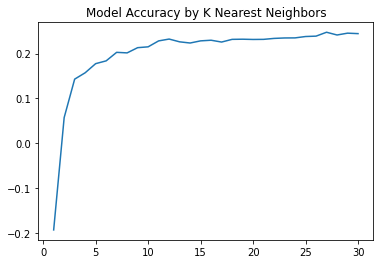

In [2684]:
plt.plot(k_range, scores)
plt.title('Model Accuracy by K Nearest Neighbors')

### Linear Regression ###
Linear regression is a linear model, meaning it assumes that y can be calculated from a linear combination of the input variables, x, and tries to calculate that very combination.

In [2685]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2686]:
regressor = LinearRegression()
score = np.median(cross_val_score(regressor, x_train, y_train, cv=30))

print('Score: {}'.format(score))

Score: 0.2834779533476689


### Decision Tree Regressor ###
Decision Tree is a decision-making tool that uses a flowchart-like tree structure or is a model of decisions and all of their possible results, including outcomes, input costs, and utility. <br>
The decision hierarchy would be determined by each factor's gini impurity score (lowest preferred, and would be constructed of boolean conditions. In case we find a score of 0 we would know this factor is a leaf [the end of the tree and the deciding factor]). Once the gini impurity reaches a certain threshold of irrelevance we would conclude the decision path with a final boolean decision determined by the most common result.

Import 'DecisionTreeRegressor'.

In [2687]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

Lets find the most suitable Depth.

In [2688]:
depth_range = range(1,31)

scores = []
for depth in depth_range:
    regressor = DecisionTreeRegressor(max_depth=depth)
    score = np.median(cross_val_score(regressor, x_train, y_train, cv=30))
    scores.append(score)

max_depth_score = np.max(scores[1:])
max_depth = scores.index(max_depth_score) + 1
print('Score: {}, Best Performing Max Depth: {}'.format(max_depth_score, max_depth))

Score: 0.24079238126256186, Best Performing Max Depth: 8


Text(0.5, 1.0, 'Model Accuracy by Max Depth')

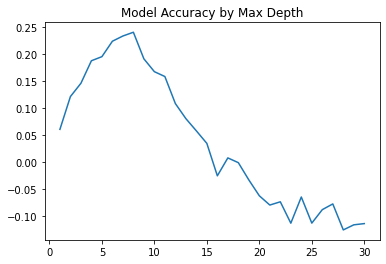

In [2689]:
plt.plot(depth_range, scores)
plt.title('Model Accuracy by Max Depth')

### Random Forest Regressor ###
A random forest is a meta estimator that fits a number of classifying decision trees on various random sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Import 'RandomForestRegressor'.

In [2690]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2691]:
regressor = RandomForestRegressor()
score = np.median(cross_val_score(regressor, x_train, y_train, cv=30))

print('Score: {}'.format(score))

Score: 0.4047125013187971


### Measure of Errors ###

First we will check the Coefficient of Determination (R2) to see how well each model predicts the data it was fitted with.

In [2692]:
from sklearn.metrics import r2_score

def R2score(model, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    score = r2_score(y_train, y_pred)
    print( model_name + ': {}'.format(score) )

R2score( RandomForestRegressor(), 'RandomForestRegressor')
R2score( KNeighborsRegressor(n_neighbors=max_k), 'KNeighborsRegressor')
R2score( DecisionTreeRegressor(max_depth=max_depth), 'DecisionTreeRegressor')
R2score( LinearRegression(), 'LinearRegression')
R2score( DummyRegressor(strategy="mean"), 'DummyRegressor')

RandomForestRegressor: 0.9146433849933754
KNeighborsRegressor: 0.3019899407901647
DecisionTreeRegressor: 0.41011276641379013
LinearRegression: 0.29095131840714294
DummyRegressor: 0.0


We can see that the dummy model is perfect at predicting the results of the data it was fitted with (result of 0) while all of the other models, besides knn, performed well too.

Next we will use Mean Absolute Error to determine out average error range. We did not use Mean Square Error since we do not plan to graph it or apply any mathematical operation, we needed a score that is easy for a human to understand immediately.

In [2696]:
def MAEscore(model, model_name):
    score = np.median( np.abs( cross_val_score(model, x_test, y_test, cv=30, scoring='neg_mean_absolute_error') ) )
    print( model_name + ': {}'.format(score) )

MAEscore( RandomForestRegressor(criterion='absolute_error'), 'RandomForestRegressor')
MAEscore( KNeighborsRegressor(n_neighbors=max_k), 'KNeighborsRegressor')
MAEscore( DecisionTreeRegressor(max_depth=max_depth), 'DecisionTreeRegressor')
MAEscore( LinearRegression(), 'LinearRegression')
MAEscore( DummyRegressor(strategy="mean"), 'DummyRegressor')

RandomForestRegressor: 1142.3284274193547
KNeighborsRegressor: 1326.6952077525555
DecisionTreeRegressor: 1309.543668930834
LinearRegression: 1271.105961889984
DummyRegressor: 1515.23953182976


In [2697]:
MAEscore( RandomForestRegressor(), 'RandomForestRegressor')
MAEscore( KNeighborsRegressor(n_neighbors=max_k), 'KNeighborsRegressor')
MAEscore( DecisionTreeRegressor(max_depth=max_depth), 'DecisionTreeRegressor')
MAEscore( LinearRegression(), 'LinearRegression')
MAEscore( DummyRegressor(strategy="mean"), 'DummyRegressor')

RandomForestRegressor: 1174.3298522145417
KNeighborsRegressor: 1326.6952077525555
DecisionTreeRegressor: 1295.5385512890384
LinearRegression: 1271.105961889984
DummyRegressor: 1515.23953182976


We can see that all our models far surpassed the dummy model's score signifying a success. Especially Random Forest our final, best module.